In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
import seaborn as sns
# import random
from matplotlib import cm

In [2]:
df = pd.read_csv('data/data_2dmap.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54208 entries, 0 to 54207
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      54208 non-null  float64
 1   X2      54208 non-null  float64
 2   Y       20463 non-null  float64
dtypes: float64(3)
memory usage: 1.2 MB


In [3]:
idx_nan = df[pd.isna(df['Y'])].index
df = df.drop(idx_nan).reset_index(drop=True)
len(df)

20463

In [4]:
df.head()

,X1,X2,Y
0,32.001173,-103.529415,116.171346
1,32.638369,-103.890820,55.907091
2,32.281932,-103.696137,61.696657
3,32.647904,-103.780955,69.408398
4,32.711780,-103.968117,81.420442


In [5]:
len(df), len(df)-230

(20463, 20233)

In [6]:
df = df[~df.duplicated(keep='first')]
len(df)

20233

In [7]:
df[df.duplicated(keep='first')]

,X1,X2,Y


In [12]:
df.groupby(['X1', 'X2']).size().groupby(level=2).max()

IndexError: Too many levels: Index has only 2 levels, not 3

In [9]:
dfp = df.pivot(index='X2', columns='X1', values='Y')
dfp.head()

ValueError: Index contains duplicate entries, cannot reshape

In [14]:
df.head()

,X1,X2,Y
1,32.001173,-103.529415,116.171346
3,32.638369,-103.890820,55.907091
4,32.281932,-103.696137,61.696657
5,32.647904,-103.780955,69.408398
6,32.711780,-103.968117,81.420442


In [14]:
X1 = df['X1'].values
X2 = df['X2'].values
Y  = df['Y'].values

In [30]:
nd = 1
z1, z2 = np.meshgrid(np.linspace(X1.min(), X1.max(), nd), np.linspace(X2.min(), X2.max(), nd))
Z = np.concatenate([z1.reshape(nd*nd, 1), z2.reshape(nd*nd, 1)], 1)

In [31]:
Z.shape

(1, 2)

In [37]:
X1.min(), X1.max(), X2.min(), X2.max()

(30.71624952, 33.38342308, -104.5949871, -100.8286235)

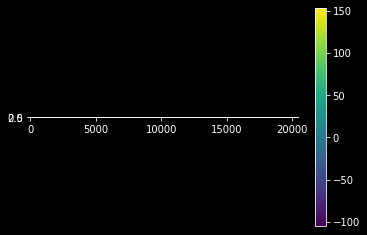

In [50]:
x,y  = np.meshgrid(np.arange(30, 34), np.arange(-104, -100) )
data = np.random.randint(0,2, size=(20,20))

#===Plot===#
plt.subplot(111)
plt.imshow((X1, X2, Y), interpolation="None")
plt.colorbar();

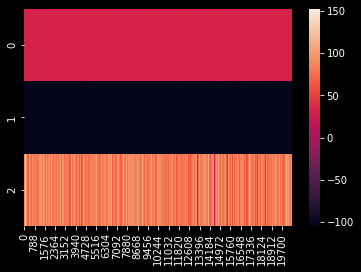

In [51]:
sns.heatmap((X1, X2, Y));

In [ ]:
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

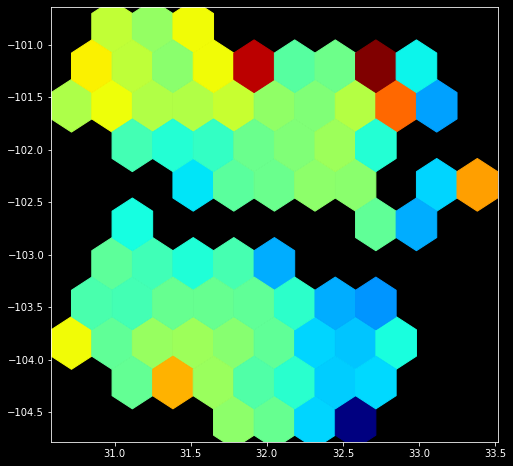

In [31]:
from matplotlib import cm
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
img = ax.hexbin(X1, X2, C=Y, gridsize=10, cmap=cm.jet);
# ax.pcolormesh(X1, X2, Y)
# ax.contour(X1, X2, Y, 20, cmap='RdGy');
# plt.colorbar(img);

In [25]:
a = np.random.random((16, 16))
a.shape

(16, 16)

ValueError: Index contains duplicate entries, cannot reshape

In [62]:
len(df) - 230

20233

20463

In [13]:
# from https://github.com/fonnesbeck/gp_regression/blob/master/notebooks/multidimensional_gp.ipynb
df = pd.read_table('../data/GP-Walker.txt', sep='\s+', index_col=0, skiprows=8, header=None, 
                   names=['ID', 'Xloc', 'Yloc', 'V', 'U', 'T'])
df.head()

,Xloc,Yloc,V,U,T
ID,,,,,
1,11,8,0.0,1.000000e+31,2
2,8,30,0.0,1.000000e+31,2
3,9,48,224.4,1.000000e+31,2
4,8,69,434.4,1.000000e+31,2
5,9,90,412.1,1.000000e+31,2


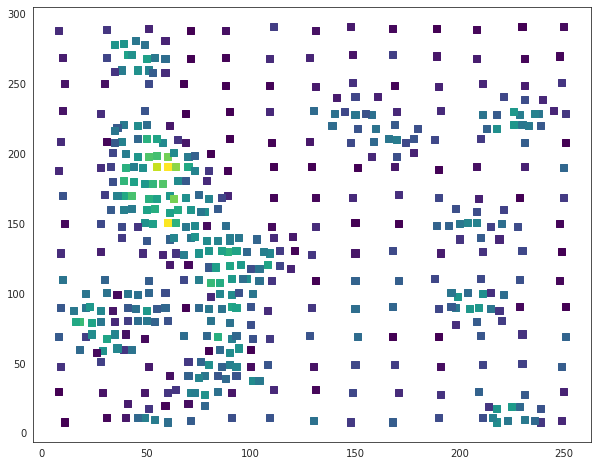

In [14]:
nx = 40
x1, x2 = np.meshgrid(np.linspace(0,300,nx), np.linspace(0,300,nx))
X = np.concatenate([x1.reshape(nx*nx, 1), x2.reshape(nx*nx, 1)], 1)

X_obs = df[['Xloc', 'Yloc']].values
y_obs = df.V.values

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(df['Xloc'], df['Yloc'], c=df['V'], s=50, marker='s', cmap=plt.cm.viridis);

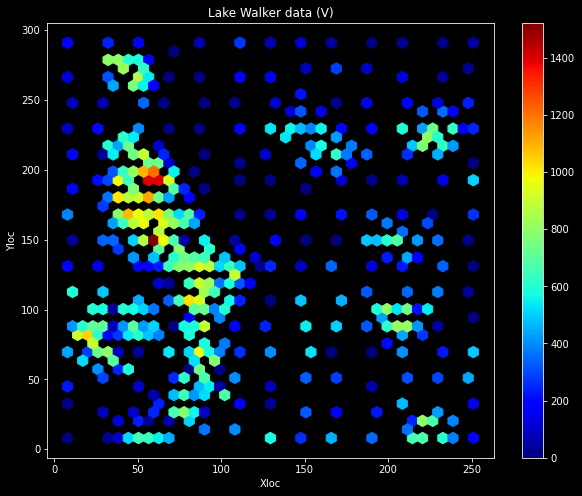

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
img = ax.hexbin(df['Xloc'], df['Yloc'], C=df['V'], gridsize=40, cmap=cm.jet)
ax.set(xlabel='Xloc', ylabel='Yloc', title='Lake Walker data (V)')
plt.colorbar(img);

In [16]:
nd = 15
xu1, xu2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1)

In [17]:
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [18]:
with pm.Model() as spatial_model:
    
    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)
    sn2 = pm.HalfCauchy("sn2", beta=3)

    K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    
    gp_spatial = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    obs = gp_spatial.marginal_likelihood("obs", X=X_obs, Xu=Xu, y=y_obs, noise=sn2)

    mp = pm.find_MAP()

In [25]:
nd = 30
z1, z2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Z = np.concatenate([z1.reshape(nd*nd, 1), z2.reshape(nd*nd, 1)], 1)

with spatial_model:
    f_predi = gp_spatial.conditional('f_predi', Z)
    samples = pm.sample_posterior_predictive([mp], var_names=['f_predi'], samples=100)

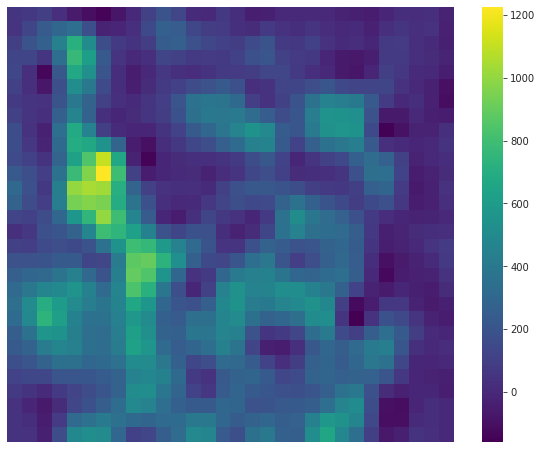

In [26]:
with sns.axes_style("white"):

    plt.figure(figsize=(10,8))
    ax = sns.heatmap(samples['f_predi'].mean(0).reshape(nd, nd), cmap='viridis')
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.set_xticklabels([])